# High Quality Image Generation with Progressive Growing of GANs

Welcome! In the previous lab, we learned how to generate pixelated CryptoPunks using Wasserstein GAN. In this, we will learn how to generate high resolution images of human faces using Progressive Growing of GANs.

**GPU** is recomended for this assignment. `Runtime` -> `Change runtime type` -> `GPU`

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- How to implement weight scaling for a better optimization
- How to use pixel-wise normalization
- How to build a Progressive GAN model
- How to train the model

# 0 - Set up the environment

In [ ]:
!pip install torchviz
!pip install wget

## Download data

In [ ]:
import wget

wget.download(
    'https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/6_generative_models/progressive_gan/template.zip')
!unzip -q template.zip

# 1 - Import packages

We will use [torchviz](https://github.com/szagoruyko/pytorchviz) package to visualize our networks.

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid

import os, shutil
import numpy as np
from torchviz import make_dot
from collections import OrderedDict
from matplotlib import pyplot as plt

%matplotlib inline

## Introduction

In this lab, we will implement Progressive GAN. Since the original [paper](https://arxiv.org/pdf/1710.10196.pdf) was published at ICLR 2018, the model became a breakthrough for generating high-resolution images. Its revolutionary idea of learning how to generate images **progressively**, from low resolutions to high, became a central focus of the modern GAN research. Its successors, [StyleGAN](https://arxiv.org/pdf/1710.10196.pdf), [StyleGAN2](https://arxiv.org/pdf/1812.04948.pdf), and [AliasFree GAN](https://nvlabs.github.io/alias-free-gan/), inherited many features of Progressive GAN and became current state-of-the-art models in image generation.

### Progressive GAN Abstract [[src](https://arxiv.org/pdf/1710.10196.pdf)]:

We describe a new training methodology for generative adversarial networks. The key idea is to grow both the generator and discriminator progressively: starting from a low resolution, we add new layers that model increasingly fine details as training progresses. This both speeds the training up and greatly stabilizes it, allowing us to produce images of unprecedented quality, e.g., CelebA images at $1024^2$

## Config

During training of Progressive GAN, `level` variable defines the resolution of training images. In original, page it's a float number between $0$ and $8$, where $8$ is a `max_level`. We will set `max_level` to $5$ because of the computation limitations.

* `max_level` - number of 2x upscaling from $4 × 4$ resolution. The size of the image during training is defined as $4*2^{level}$
* `max_resolution` - is defined as $4*2^{max\_level}$, which is $128$ in our case

In [2]:
# VALIDATION_FIELD[cls] Config

class Config:
    # data
    data_dir = './CelebA'
    batch_size = 128
    norm_mean = (0.5, 0.5, 0.5)
    norm_std = (0.5, 0.5, 0.5)

    # model
    max_level = 5
    max_resolution = 128
    nc = 3
    nz = 150
    ngf = 16
    ndf = 16

    # training
    logdir = './logs'
    seed = 21
    num_epochs = 150
    learning_rate = 0.0001
    train_D_steps = 1
    eval_every = 50
    save_every = 100
    clip = 0.01
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)


set_seed(Config.seed)

# 2 - Data Preprocessing and loading

## Data Transforms

In [4]:
transform = transforms.Compose([
    transforms.Resize(Config.max_resolution),
    transforms.CenterCrop(Config.max_resolution),
    transforms.ToTensor(),
    transforms.Normalize(Config.norm_mean, Config.norm_std)
])

## Dataset & DataLoader

In [5]:
data = ImageFolder(Config.data_dir, transform=transform)
dataloader = DataLoader(
    data,
    batch_size=Config.batch_size,
    shuffle=True,
    num_workers=2
)

## Visualize a batch of data

In [6]:
def visualize_batch(batch, title=None, save=None, mean=Config.norm_mean, std=Config.norm_std):
    # create grid
    grid = make_grid(batch, nrow=int(np.sqrt(len(batch))))
    # tensor -> array
    np_grid = grid.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    np_grid = (np_grid * std + mean).clip(0, 1)

    # show or save figure
    plt.figure(figsize=(16, 12))
    plt.axis("off")
    plt.imshow(np_grid)
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
        plt.close()
    else:
        plt.show()
    return grid

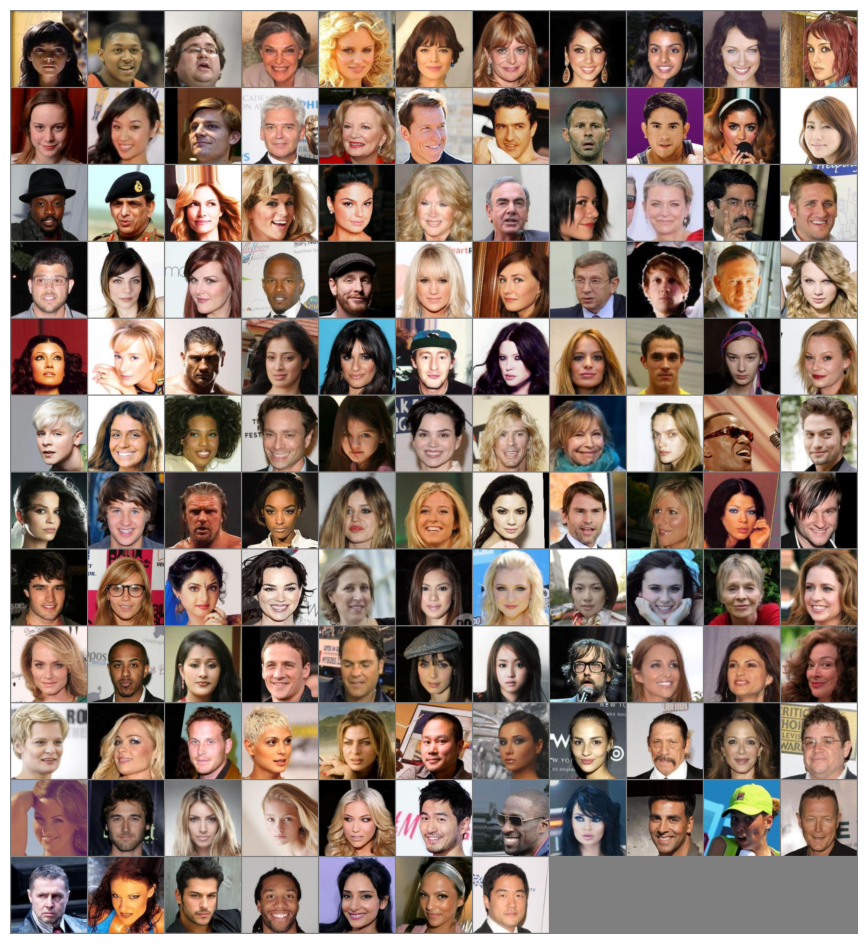

In [7]:
batch, _ = next(dataloader.__iter__())
grid = visualize_batch(batch)

## Downsample the images

As mentioned before, we will use the `level` variable to denote the image resolution that we are training at. The resolution of the image is defined using the formula $resolution = 4*2^{level}$. Therefore, we need to have a function that downsamples the batch of images. 

| level      | 0   | 1   | 2     | 3     | 4     | 5       | 6       | 7       | 8         |
|------------|-----|-----|-------|-------|-------|---------|---------|---------|-----------|
| resolution | 4x4 | 8x8 | 16x16 | 32x32 | 64x64 | 128x128 | 256x256 | 512x512 | 1024x1024 |


**Excercise:** 

Implement a function `downsample` that downsamples a batch of images to the needed resolution. **Note** that level is a float number, **NOT** an integer. So, for example, if the `level` is a number between $0$ and $1$, you should use the resolution of the next integer level ($8x8$ in this case). Also, your resolution **CANNOT** exceed `max_resolution`. **Use** `F.adaptive_avg_pool2d` to perform the resize.

In [8]:
# VALIDATION_FIELD[func] downsample

def downsample(batch, level, max_resolution=Config.max_resolution):
    ### START CODE HERE ### (≈4 lines of code)
    ceiled_level = int(np.ceil(level))
    resolution = min(max_resolution, 4 * 2 ** ceiled_level)
    downsampled_batch = F.adaptive_avg_pool2d(batch, resolution)
    ### END CODE HERE ###
    return downsampled_batch

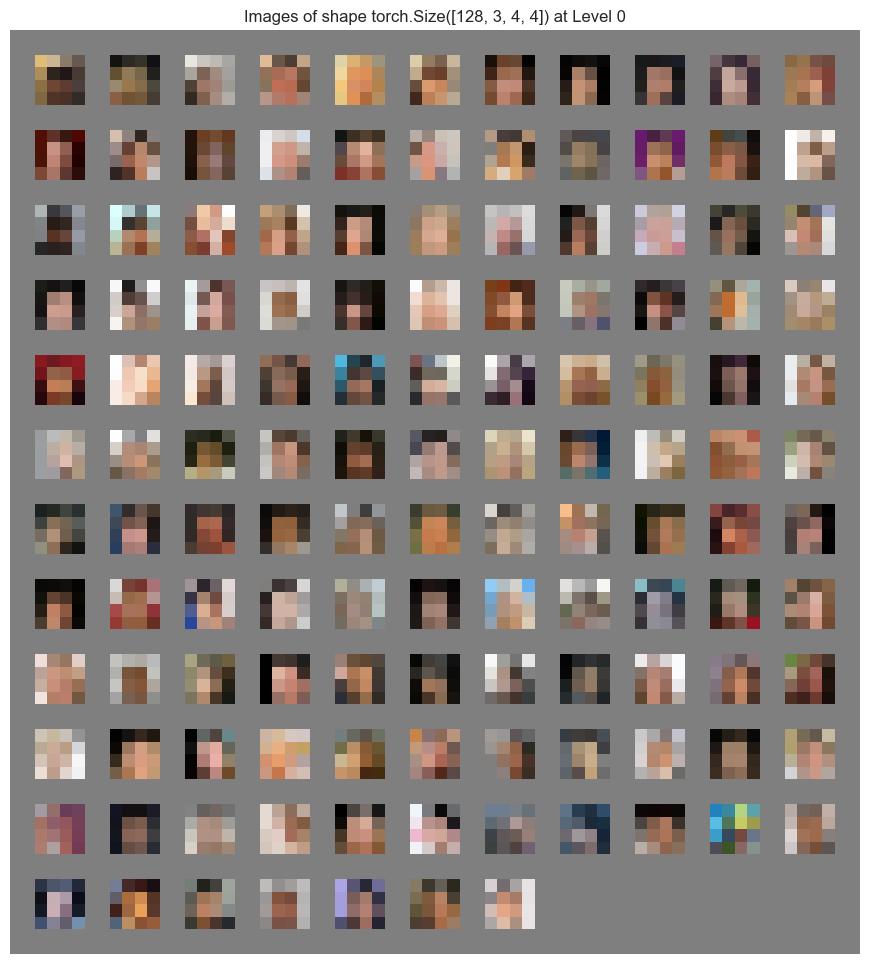

In [9]:
downsampled = downsample(batch, 0)
visualize_batch(downsampled, title=f'Images of shape {downsampled.shape} at Level 0');

**Expected output:**
<table>
<tr>
    <td> <b>image shape</b> </td>
    <td> torch.Size([128, 3, 4, 4]) </td>
</tr>
</table>

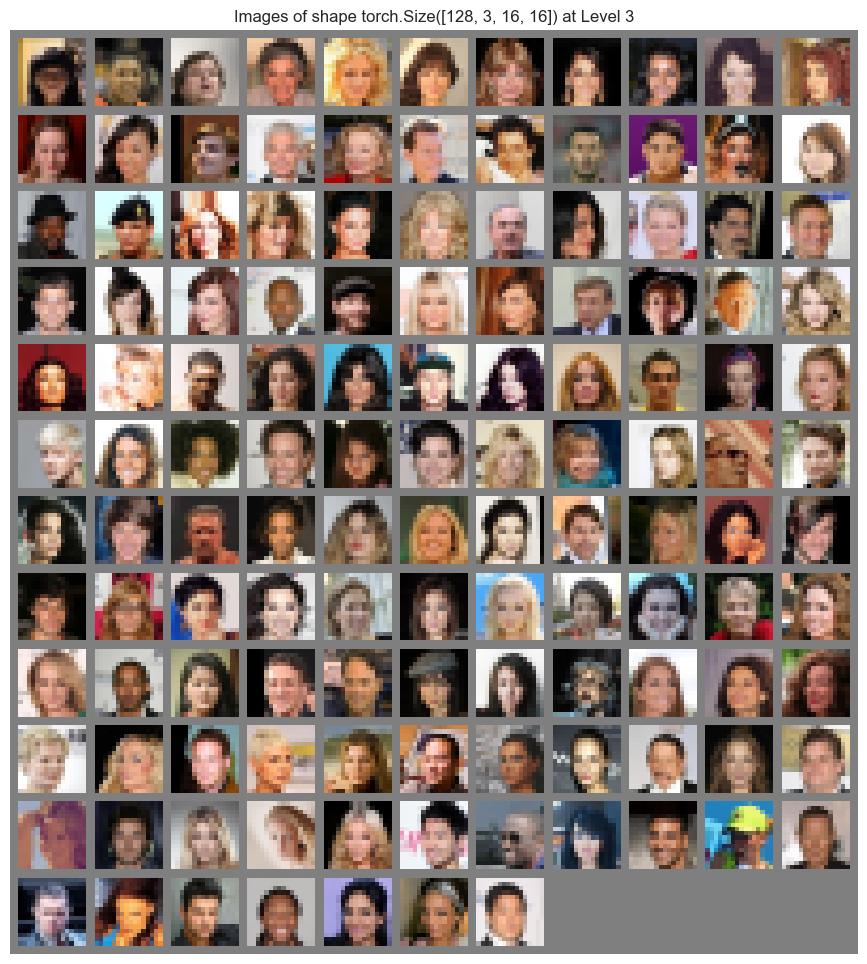

In [10]:
downsampled = downsample(batch, 1.3)
visualize_batch(downsampled, title=f'Images of shape {downsampled.shape} at Level 3');

**Expected output:**
<table>
<tr>
    <td> <b>image shape</b> </td>
    <td> torch.Size([128, 3, 16, 16]) </td>
</tr>
</table>

# 3 - Model 

The idea behind the progressive growing of GAN is that we start with low-resolution images and then progressively increase the resolution by adding layers to the networks as visualized in the figure from [the original paper](https://arxiv.org/pdf/1710.10196.pdf):

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/progressive_training.png">

The training starts with both the generator ($G$) and discriminator ($D$) having a low spatial resolution of $4×4$ pixels. As the training advances, we incrementally add layers to $G$ and $D$, thus increasing the spatial resolution of the generated images. All existing layers remain trainable throughout the process. Here $\boxed{N × N}$ refers to convolutional layers operating on $N × N$ spatial resolution. This allows stable synthesis in high resolutions and also speeds up training considerably. On the right, we show six example images generated using progressive growing at $1024 × 1024$.

### Level of training

| level      | 0   | 1   | 2     | 3     | 4     | 5       | 6       | 7       | 8         |
|------------|-----|-----|-------|-------|-------|---------|---------|---------|-----------|
| resolution | 4x4 | 8x8 | 16x16 | 32x32 | 64x64 | 128x128 | 256x256 | 512x512 | 1024x1024 |

As we mentioned before, during training, we will use `level` to control the current resolution of the images. For example, when `level=3`, we will train on $64 × 64$ resolution. To do so, we will pass the latent vector through the first $4$ convolutional blocks to obtain a tensor with resolution $64 × 64$. For the discriminator, everything is the same but in reverse. We will pass the output through the 4th, 3rd, 2nd, and 1st convolutional block (in that order) to obtain the output.

### Alpha transition

When we reach a new level of training, we do not want to simply stack a new untrained layer on the top of our network. That will destabilize the training process, which will lead to poor optimization. Instead, we want to fade in the new layers smoothly.

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/alpha_transition.png">

This example illustrates the transition from $16 × 16$ images (a) to $32 × 32$ images (c). During the transition (b), we treat the layers that operate on the higher resolution like a residual block, whose weight $\alpha$ increases linearly from 0 to 1. Here $\boxed{2×}$ and $\boxed{0.5×}$ refer to doubling and halving the image resolution using nearest neighbor filtering and average pooling, respectively. The $\boxed{\text{toRGB}}$ represents a layer that projects feature vectors to RGB colors and $\boxed{\text{fromRGB}}$ does the reverse; both use $1 × 1$ convolutions. When training the discriminator, we feed in real images that are downscaled to match the current resolution of the network. During a resolution transition, we interpolate between two resolutions of the real images, similarly to how the generator output combines two resolutions.

### Implementation details

Note that in the original architecture, authors used **same** padding in `Conv2d` blocks of the discriminator, and then downscaled the images using average pooling. In our implementation, we will use a strided convolution (`stride=2`) to combine two operations in one layer.

## Weight Scaling 

One of the innovations of the Progressive GAN is a new weight scaling method, which applies to every trainable weight in the model. Instead of careful weight initialization, authors of Progressive GAN choose to use a trivial $N(0, 1)$ initialization and then explicitly scale the weights at runtime. More concretely, they multiply each weight in the layer by a scaling factor $c = \sqrt{2/N}$, where N is a number of parameters in the given layer.

**Excercise:** Implement `WScaleLayer` that calculates the scaling factor $c$, and then multiplies the inputs to this layer by $c$.

$$ \hat{w}_{i}=w_{i} * c $$

$$ c = \sqrt{ 2 / N } $$

In [11]:
# VALIDATION_FIELD[cls] WScaleLayer

class WScaleLayer(nn.Module):
    def __init__(self, incoming):
        super(WScaleLayer, self).__init__()
        N = incoming.weight[0].numel()
        ### START CODE HERE ### (1 line of code)
        self.c = np.sqrt(2 / N)
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (1 line of code)
        x = self.c * x
        ### END CODE HERE ###
        return x

In [12]:
set_seed(Config.seed)
layer = nn.Conv2d(4, 3, 3)
scaler = WScaleLayer(layer)
print('scale factor:', scaler.c)

x = torch.randn(1, 4, 3, 3)
x = scaler(x)
x = layer(x)
print('output:', x)

scale factor: 0.23570226039551584
output: tensor([[[[-0.3053]],

         [[ 0.1217]],

         [[ 0.4188]]]], grad_fn=<ConvolutionBackward0>)


**Expected output:**
<table>
<tr>
    <td> <b>scale factor</b> </td>
    <td> 0.23570226039551584 </td>
</tr>
  <tr>
    <td> <b>output</b> </td>
    <td> tensor([[[[-0.3053]],<br>
<br>
         [[ 0.1217]],<br>
<br>
         [[ 0.4188]]]] </td>
</tr>
</table>

## Pixelwise Normalization

To disallow the scenario where the magnitudes in the generator and discriminator spiral out of control as a result of competition, we normalize the feature vector in each pixel to unit length in the
generator after each convolutional layer:

$$ b_{x, y}=a_{x, y} / \sqrt{\frac{1}{N} \sum_{j=0}^{N-1}\left(a_{x, y}^{j}\right)^{2}+\epsilon} $$

where $\epsilon=10^{-8}$, $N$ is a number of feature maps (number of channels), and $a_{x, y}$ and $b_{x, y}$ are the original and normalized feature vector in pixel $(x, y)$, respectively.

**Excercise:** Implement pixelwise normalization layer. 

In [13]:
# VALIDATION_FIELD[cls] PixelNormLayer

class PixelNormLayer(torch.nn.Module):
    def __init__(self, e=1e-8):
        super(PixelNormLayer, self).__init__()
        self.e = e

    def forward(self, x):
        ### START CODE HERE ### (1 line of code)
        x = x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.e)
        ### END CODE HERE ###
        return x

In [14]:
set_seed(Config.seed)
l = PixelNormLayer()
pixels = torch.randn(1, 3, 2, 2)
print('original:', pixels)
print('normalized:', l(pixels))

original: tensor([[[[ 0.1081, -0.4376],
          [-0.7697, -0.1929]],

         [[-0.3626, -2.8451],
          [ 1.4435,  0.4976]],

         [[ 0.6542,  0.0754],
          [-1.0767,  0.1269]]]])
normalized: tensor([[[[ 0.2478, -0.2632],
          [-0.6807, -0.6091]],

         [[-0.8310, -1.7113],
          [ 1.2767,  1.5711]],

         [[ 1.4994,  0.0454],
          [-0.9522,  0.4008]]]])


**Expected output:**
<table>
<tr>
    <td> <b>original</b> </td>
    <td> tensor([[[[ 0.1081, -0.4376],<br>
          [-0.7697, -0.1929]],<br>
<br>
         [[-0.3626, -2.8451],<br>
          [ 1.4435,  0.4976]],<br>
<br>
         [[ 0.6542,  0.0754],<br>
          [-1.0767,  0.1269]]]]) </td>
</tr>
  <tr>
    <td> <b>normalized</b> </td>
    <td> tensor([[[[ 0.2478, -0.2632],<br>
          [-0.6807, -0.6091]],<br>
<br>
         [[-0.8310, -1.7113],<br>
          [ 1.2767,  1.5711]],<br>
<br>
         [[ 1.4994,  0.0454],<br>
          [-0.9522,  0.4008]]]])</td>
</tr>
</table>

## Generic Convolutional Block

Most of the convolutional blocks in the Progressive GAN are composed of the following layers:

1. WScaleLayer
2. nn.ConvTranspose2d in $G$ or nn.Conv2d in $D$
3. nn.BatchNorm2d
4. ReLU in $G$ or LeakyReLU in $D$
5. PixelNormLayer

Below, we will define a generic convolutional layer that combines all 5 layers into one `nn.Sequential` block.

In [15]:
# VALIDATION_FIELD[cls] get_conv_block

def get_conv_block(in_ch, out_ch, k_size, stride, padding, bias=False,
                   layer=nn.Conv2d, batch_norm=False, activation=nn.ReLU,
                   pixel_norm=False, wscaler=False):
    conv = layer(in_ch, out_ch, k_size, stride, padding, bias=bias)
    layers = OrderedDict()

    if wscaler:
        layers['weight_scale'] = WScaleLayer(conv)

    layers['conv'] = conv

    if batch_norm:
        layers['batch_norm'] = nn.BatchNorm2d(out_ch)

    if activation:
        layers['activ'] = activation()

    if pixel_norm:
        layers['pixel_norm'] = PixelNormLayer()

    return nn.Sequential(layers)

## Generator

### Generator's Double Convolutional Block

The main block of the Generator is a double convolutional block, similar to the one we implemented in the WGAN lab. The first convolutional block uses a transpose convolution with `kernel_size=4` and `stride=2` to upscale the resolution of the input `x` by a factor of $2$. The second convolutional layer uses a $1 × 1$ convolutions to change the number of channels in the `x`. 

**Excercise:** Implement `GDoubleConv` using `get_conv_block` and specifications below (all other arguments are default).

* `self.conv1`:
    * input number of channels = in_ch
    * output number of channels = in_ch
    * kernel size = 4
    * stride = 2
    * padding = 1
    * layers = `WScaler -> ConvTranspose2d -> BatchNorm2d -> ReLU -> PixelNormLayer`
* `self.conv2`:
    * input number of channels = in_ch
    * output number of channels = out_ch
    * kernel size = 1
    * stride = 1
    * padding = 0
    * layers = `WScaler -> ConvTranspose2d -> BatchNorm2d -> ReLU -> PixelNormLayer`
  

In [16]:
# VALIDATION_FIELD[cls] GDoubleConv

class GDoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(GDoubleConv, self).__init__()
        ### START CODE HERE ### (≈4 lines of code)
        # upsample to 2x original size
        self.conv1 = get_conv_block(in_ch, in_ch, 4, 2, 1, layer=nn.ConvTranspose2d, batch_norm=True,
                                    activation=nn.ReLU, pixel_norm=True, wscaler=True)
        # 1x1 convolutions to decrease number of channels 
        self.conv2 = get_conv_block(in_ch, out_ch, 1, 1, 0, layer=nn.ConvTranspose2d, batch_norm=True,
                                    activation=nn.ReLU, pixel_norm=True, wscaler=True)
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (≈2 lines of code)
        x = self.conv1(x)
        x = self.conv2(x)
        ### END CODE HERE ###
        return x

In [17]:
set_seed(Config.seed)
l = GDoubleConv(10, 5)
x = torch.randn(1, 10, 2, 2)
print('output shape:', l(x).shape)

output shape: torch.Size([1, 5, 4, 4])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td>torch.Size([1, 5, 4, 4])</td>
</tr>
</table>

### Generator's first Convolutional Block

This block is slightly different from `GDoubleConv` because it has `stride=1` instead of $2$ and `padding` is $0$. This helps to convert the input $z$ from shape `[batch, 150, 1, 1]` to `[batch, ngf, 4, 4]`, skipping $2 × 2$ resolution. 

**Excercise:** Implement `GInputConv` asccording to the specifications. (all other arguments are default).

* `self.conv1`:
    * input number of channels = in_ch
    * output number of channels = in_ch
    * kernel size = 4
    * stride = 1
    * padding = 0
    * layers = `WScaler -> ConvTranspose2d -> BatchNorm2d -> ReLU -> PixelNormLayer`
* `self.conv2`:
    * input number of channels = in_ch
    * output number of channels = out_ch
    * kernel size = 1
    * stride = 1
    * padding = 0
    * layers = `WScaler -> ConvTranspose2d -> BatchNorm2d -> ReLU -> PixelNormLayer`

In [24]:
# VALIDATION_FIELD[cls] GInputConv

class GInputConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(GInputConv, self).__init__()
        ### START CODE HERE ### (≈4 lines of code)
        self.conv1 = get_conv_block(in_ch, in_ch, 4, 1, 0, layer=nn.ConvTranspose2d, batch_norm=True,
                                    activation=nn.ReLU, pixel_norm=True, wscaler=True)
        self.conv2 = get_conv_block(in_ch, out_ch, 1, 1, 0, layer=nn.ConvTranspose2d, batch_norm=True,
                                    activation=nn.ReLU,
                                    pixel_norm=True, wscaler=True)
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (≈2 lines of code)
        x = self.conv1(x)
        x = self.conv2(x)
        ### END CODE HERE ###
        return x

In [25]:
layer = GInputConv(150, 32)
x = torch.randn(1, 150, 1, 1)
print('output shape:', layer(x).shape)

output shape: torch.Size([1, 32, 4, 4])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td>torch.Size([1, 32, 4, 4])</td>
</tr>
</table>

### toRGB block

`toRGB` block is a single convolutional block that uses $1 × 1$ convolutions to transform the input number of channels to three RGB channels.

**Excercise:** Implement `toRGB` block according to the specifications below. (all other arguments are default).

* `self.conv`:
    * input number of channels = in_ch
    * output number of channels = nc (3 in our config)
    * kernel size = 1
    * stride = 1
    * padding = 0
    * layers = `WScaler -> ConvTranspose2d -> Tanh`

In [26]:
# VALIDATION_FIELD[cls] toRGB 

class toRGB(nn.Module):
    def __init__(self, in_ch, nc):
        super(toRGB, self).__init__()
        ### START CODE HERE ### (≈4 lines of code)
        self.conv = get_conv_block(in_ch, nc, 1, 1, 0, layer=nn.ConvTranspose2d, batch_norm=False,
                                   activation=nn.Tanh, pixel_norm=False, wscaler=True)
        ### END CODE HERE ### 

    def forward(self, x, activation=True):
        ### START CODE HERE ### (≈1 lines of code)
        x = self.conv(x)
        ### END CODE HERE ###
        return x

In [27]:
layer = toRGB(16, 3)
x = torch.randn(1, 16, 4, 4)
print('output shape:', layer(x).shape)

output shape: torch.Size([1, 3, 4, 4])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td>torch.Size([1, 3, 4, 4])</td>
</tr>
</table>

### Generator design

Before we start describing the Configuration of the Generator, let's define some notations.

**Vocab:**

* `level` - float number that characterizes the current state of training.
* `c_level` - (ceiled `level`) the least integer greater than or equal to `level`
* `max_level` - number of 2x upscaling from 4x4 resolution. The size of the image during training is defined as $4*2^{level}$. Therefore, the maximum resolution is $4*2^{max\_level}$
* `block in` - input number of channels for the convolutional block at a given level
* `block out` - output number of channels for the convolutional block at a given level
* `toRGB in` - input number of channels for the `toRGB` layer at a given level
* `toRGB out` - output number of channels for the `toRGB` layer at a given level
* `nz` - size of the input noize vector (150 by default)
* `ngf` - default number of feature maps in the generator
* `nc` - number of image channels (3 by default)

### Design

The role of the generator is to transform a latent vector $z$ (of shape $[\text{batch}, \text{nz}, 1, 1]$) into a batch of images (of shape $[\text{batch}, 3, 4*2^{\text{c_level}}, 4*2^{\text{c_level}}]$ where $\text{c_level}$ is the least integer greater than or equal to `level`. 

So, for example, if we are at the $\text{level}=2.5$, $\text{c_level}=3$, our generator should return $[\text{batch}, 3, 32, 32]$. This is done through a sequence of convolutional layers (`blocks[i]`, where $i\in[0, \text{c_level}]$) that upscales the resolution of the image, and $\text{c_level}$-th `toRGB` layer (`toRGB[c_level]`) that maps the output to a $3$ channel space. At each layer, generator **decreases** the number of channels and **increases** the spatial dimension of the input. 


### `__init__`

Generally, a generator operates using $\text{level}\in{[0, \text{max_level}]}$. So, in the `__init__` function you should initialize $\text{max_level} + 1$ number of `toRGB` and `block` layers (for each resolution of images). We always want the last `blocks` layer to have $\text{ngf}×1$ number of channels, and we do not want our number of channels to ever exceed $\text{ngf}×32$. See examples of correct configuration for different $\text{max_level}$ below.


### `forward`

In forward, we just have to pass the latent vector $z$ through $\text{c_level}$ layers of our `block` layers. We also have to remember our second to last output because we will need it for alpha transition. The last output of the neural network we have to pass through the `toRGB[c_level]` layer. During the **alpha transition**, we have to upsample the second to last output using `F.interpolate`, pass it through `toRGB[c_level-1]` layer, and combine two outputs using the formula below.

$$ \text{out} = x_1 \alpha + x_2 (1 - \alpha) $$
 
Where $x_1$ is the last output of `blocks`, and $x_2$ is a second to last output of `blocks`.

**Excercise:** Implement `__init__` and `forward` functions of the generator. See configurations below for more details.


---
**Network Configuration if `max_level=3`**

| level         | 0         | 1         | 2         | 3         |
|-------------  |-------    |-------    |-------    |-------    |
| resolution    |  4x4      | 8x8       | 16x16     | 32x32     |
| block in      | nz        | ngfx8     | ngfx4     | ngfx2     |
| block out     | ngfx8     | ngfx4     | ngfx2     | ngfx1     |
| toRGB in      | ngfx8     | ngfx4     | ngfx2     | ngfx1     |
| toRGB out     | nc        | nc        | nc        | nc        |

---
**Network Configuration if `max_level=5`**

|     level     | 0         | 1         | 2         | 3         | 4         | 5         |
|-------------  |--------   |--------   |--------   |-------    |-------    |---------  |
| resolution    |  4x4      | 8x8       | 16x16     | 32x32     | 64x64     | 128x128   |
| block in      | nz        | ngfx32    | ngfx16    | ngfx8     | ngfx4     | ngfx2     |
| block out     | ngfx32    | ngfx16    | ngfx8     | ngfx4     | ngfx2     | ngfx1     |
| toRGB in      | ngfx32    | ngfx16    | ngfx8     | ngfx4     | ngfx2     | ngfx1     |
| toRGB out     | nc        | nc        | nc        | nc        | nc        | nc        |

---
**Network Configuration if `max_level=8`**

|     level     | 0         | 1         | 2         | 3         | 4         | 5         | 6         | 7         | 8             |
|-------------  |--------   |--------   |--------   |--------   |--------   |---------  |---------  |---------  |-----------    |
| resolution    |  4x4      | 8x8       | 16x16     | 32x32     | 64x64     | 128x128   | 256x256   | 512x512   | 1024x1024     |
| block in      | nz        | ngfx32    | ngfx32    | ngfx32    | ngfx32    | ngfx16    | ngfx8     | ngfx4     | ngfx2         |
| block out     | ngfx32    | ngfx32    | ngfx32    | ngfx32    | ngfx16    | ngfx8     | ngfx4     | ngfx2     | ngfx1         |
| toRGB in      | ngfx32    | ngfx32    | ngfx32    | ngfx32    | ngfx16    | ngfx8     | ngfx4     | ngfx2     | ngfx1         |
| toRGB out     | nc        | nc        | nc        | nc        | nc        | nc        | nc        | nc        | nc            |



In [30]:
# VALIDATION_FIELD[cls] Generator

class Generator(nn.Module):
    def __init__(
            self,
            nz=Config.nz,
            nc=Config.nc,
            ngf=Config.ngf,
            max_level=Config.max_level
    ):
        super(Generator, self).__init__()
        self.max_level = max_level

        self.blocks = torch.nn.ModuleList()
        self.toRGBs = torch.nn.ModuleList()

        ### START CODE HERE ### (≈9 lines of code)
        # add first blocks for level=0
        max_channels = ngf * min(32, 2 ** max_level)
        self.blocks.append(GDoubleConv(nz, max_channels))  # first block
        self.toRGBs.append(toRGB(max_channels, nc))  # first toRGB

        for level in range(1, max_level + 1):
            in_channels = ngf * min(32, 2 ** (max_level - level + 1))  # block in
            out_channels = ngf * min(32, 2 ** (max_level - level))  # block out
            self.blocks.append(GDoubleConv(in_channels, out_channels))
            self.toRGBs.append(toRGB(out_channels, nc))
        ### END CODE HERE ###

    def forward(self, x, level):
        ### START CODE HERE ### (≈10 lines of code)
        # calculate alpha and c_level using level
        alpha = level - int(level) if level < self.max_level else 0
        c_level = min(int(np.ceil(level)), self.max_level)

        # froward through level number of layers (saving two last outputs) 
        for l in range(0, c_level):  # pass through all but last layer
            x = self.blocks[l](x)
        x1 = x  # pass through the last layer                  
        x1 = self.toRGBs[c_level](x1)  # convert last output to rgb

        # alpha transition
        if alpha != 0:
            # upsample 
            x2 = F.interpolate(x, scale_factor=2, mode='nearest')
            # pass through the toRGB
            x2 = self.toRGBs[c_level - 1](x2)
            out = x1 * alpha + x2 * (1 - alpha)
        else:
            out = x1
        ### END CODE HERE ###
        return out

In [33]:
# test block shapes
for max_lvl in [3, 5, 8]:
    x = torch.randn(1, Config.nz, 1, 1)
    G = Generator(max_level=max_lvl)
    for i, block in enumerate(G.blocks):
        x = block(x)
        out = G.toRGBs[i](x)
        resolution = 4 * 2 ** i
        num_channels = min(Config.ngf * 32, Config.ngf * 2 ** (max_lvl - i))
        x_shape = (1, num_channels, resolution, resolution)
        print(x.shape, out.shape)
        out_shape = (1, 3, resolution, resolution)
        assert x.shape == x_shape, f'output of block[{i}] should be {x_shape}'
        assert out.shape == out_shape, f'output of toRGB[{i}] should be {out_shape}'
    print(f'max_level={max_lvl} is correct!')

torch.Size([1, 128, 2, 2]) torch.Size([1, 3, 2, 2])


AssertionError: output of block[0] should be (1, 128, 4, 4)

In [ ]:
# test forward
set_seed(Config.seed)
G = Generator(max_level=5)
x = torch.randn(1, Config.nz, 1, 1)
out = G(x, 0.5)
print('shape:', out.shape)
print('mean:', out.mean().item())
print('std:', out.std().item())

**Expected output:**
<table>
<tr>
    <td> <b>shape</b> </td>
    <td>torch.Size([1, 3, 8, 8])</td>
</tr>
    <tr>
    <td> <b>mean</b> </td>
    <td>-0.10339345782995224</td>
</tr>
<tr>
    <td> <b>std</b> </td>
    <td>0.6227303743362427</td>
</tr>
</table>

## Discrimnator

### Discrimnator's Convolutional Block

It is very similar to Generator's Block except this one uses `Conv2d` instead of `ConvTranspose2d` and activation is `LeakyReLU()`

**Excercise:** Implement `DDoubleConv` using `get_conv_block` and specifications below (all other arguments are default).

* `self.conv1`:
    * input number of channels = in_ch
    * output number of channels = in_ch
    * kernel size = 4
    * stride = 2
    * padding = 1
    * layers = `WScaler -> ConvTranspose2d -> BatchNorm2d -> ReLU`
* `self.conv2`:
    * input number of channels = in_ch
    * output number of channels = out_ch
    * kernel size = 1
    * stride = 1
    * padding = 0
    * layers = `WScaler -> ConvTranspose2d -> BatchNorm2d -> ReLU`



In [34]:
# VALIDATION_FIELD[cls] DDoubleConv

class DDoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DDoubleConv, self).__init__()
        ### START CODE HERE ### (≈14 lines of code)
        # downsample to 2x original size
        self.conv1 = nn.Sequential(
            get_conv_block(in_ch, in_ch, 4, 2, 1, layer=nn.ConvTranspose2d, batch_norm=True, activation=nn.ReLU,
                           pixel_norm=True, wscaler=True)
        )
        # 1x1 convolutions to increase number of channels
        self.conv2 = nn.Sequential(
            get_conv_block(in_ch, out_ch, 1, 1, 0, layer=nn.ConvTranspose2d, batch_norm=True, activation=nn.ReLU,
                           pixel_norm=True, wscaler=True)
        )
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (≈2 lines of code)
        x = self.conv1(x)
        x = self.conv2(x)
        ### END CODE HERE ###
        return x

In [35]:
layer = DDoubleConv(3, 6)
x = torch.randn(1, 3, 32, 32)
print('output shape:', layer(x).shape)

output shape: torch.Size([1, 6, 64, 64])


**Expected output**:
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 6, 16, 16])</td>
</tr>
</table>

### Discrimnator's Last Convolutional Block

**Excercise:** Implement `DOutputBlock` using `get_conv_block` and specifications below (all other arguments are default).

* `self.conv`:
    * input number of channels = in_ch
    * output number of channels = out_ch
    * kernel size = 2
    * stride = 1
    * padding = 0
    * bias = False
    * activation = None
    * layer = `Conv2d`


In [ ]:
# VALIDATION_FIELD[cls] DOutputBlock

class DOutputBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DOutputBlock, self).__init__()
        ### START CODE HERE ### (≈1 line of code)
        self.conv = nn.Sequential(
            get_conv_block(in_ch, out_ch, 2, 1, 0, bias=False, activation=None, layer=nn.Conv2d)
        )
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (≈1 line of code)
        x = self.conv(x)
        ### END CODE HERE ###
        return x

In [ ]:
layer = DOutputBlock(3, 1)
x = torch.randn(1, 3, 2, 2)
print('output shape:', layer(x).shape)

**Expected output**:
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 1, 1, 1])</td>
</tr>
</table>

### fromRGB Block

`fromRGB` is essentially the reverse operation of `toRGB`. The input to this layer has `nc` channels, and it maps it to `out_ch` using $1 × 1$ convolutions.

**Excercise:** Implement `fromRGB` using `get_conv_block` and specifications below (all other arguments are default).

* `self.conv`:
    * input number of channels = nc
    * output number of channels = out_ch
    * kernel size = 1
    * stride = 1
    * padding = 0
    * layers = `WScaler -> Conv2d -> LeakyReLU`

In [ ]:
# VALIDATION_FIELD[cls] fromRGB

class fromRGB(nn.Module):
    def __init__(self, nc, out_ch):
        super(fromRGB, self).__init__()
        ### START CODE HERE ### (≈5 lines of code)
        self.conv = nn.Sequential(
            get_conv_block(nc, out_ch, 1, 1, 0, layer=nn.Conv2d, activation=nn.LeakyReLU, wscaler=True)
        )
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ###
        x = self.conv(x)
        ### END CODE HERE ###
        return x

In [ ]:
layer = fromRGB(3, 64)
x = torch.randn(1, 3, 16, 16)
print('output shape:', layer(x).shape)

**Expected output**:
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 64, 16, 16])</td>
</tr>
</table>

### Discrimnator Design

The role of the discrimnator is to output a critic  for a batch of input images (of shape $[\text{batch}, 3, 4*2^{\text{c_level}}, 4*2^{\text{c_level}}]$ where $\text{c_level}$ is the least integer greater than or equal to `level`. Similarly to the generator, this is accomplished through a stack of convolutional `blocks` and `fromRGB` layers. At each layer, discriminator **increases** the number of channels and **decreases** the spatial dimension of the input. 




### `__init__`

In terms of initialization, the discriminator is very symmetrical to the generator with one small exception — there is an additional output block that is **separate** from blocks.

### `forward`

For the discriminator, the forward pass should be done in reverse. For example, the image at resolution $128 × 128$, should be passed through the 5th `fromRGB` layer and then through the blocks of layers 5, 4, 3, 2, 1, 0 (in that order), and finally through the output. 

Similarly, the **alpha transition** is also reversed, and we will implement it at the begining of the `forward` method. First, we will pass the inputs through the `fromRGB[c_level]` and `blocks[c_level]` to obtain `x1`, where $\text{c_level}$ is ceiled level . Next, we will take original inputs again, downscale them by a factor of $2$ using `F.avg_pool2d`, and feed them through `fromRGB[c_level-1]` to obtain `x2`. Then, we will apply our alpha transition formula:

$$ \text{out} = x_1 \alpha + x_2 (1 - \alpha) $$

After that, we will have to pass the inputs through the remaining blocks in reverse (starting from $\text{c_level}$ to 0). To improve the variation in the dataset, we will also compute standard deviation across the minibatch — another major contribution of Progressive GAN paper — and concatenate it with the output of the last block. Finally, we will pass the outputs through our `output` block and celebrate!

**Excercise:** Implement `__init__` and `forward` functions of the generator. See configurations below for more details. Good luck...



---
**Discrimnator Configuration if `max_level=3`**

| level       | 0      | 1     | 2     | 3     |
|-------------|--------|-------|-------|-------|
| resolution  | 4x4    | 8x8   | 16x16 | 32x32 |
| block in    | ngdx8  | ngdx4 | ngdx2 | ngdx1 |
| block out   | ngdx16 | ngdx8 | ngdx4 | ngdx2 |
| fromRGB in  | nc     | nc    | nc    | nc    |
| fromRGB out | ngdx8  | ngdx4 | ngdx2 | ngdx1 |

---

**Discrimnator Configuration if `max_level=5`**

|     level     | 0         | 1         | 2         | 3         | 4         | 5         |
|-------------  |--------   |--------   |--------   |-------    |-------    |---------  |
| resolution    |  4x4      | 8x8       | 16x16     | 32x32     | 64x64     | 128x128   |
| block in      | ngdx32    | ngdx16    | ngdx8     | ngdx4     | ngdx2     | ngdx1     |
| block out     | ngdx32    | ngdx32    | ngdx16    | ngdx8     | ngdx4     | ngdx2     |
| fromRGB in    | nc        | nc        | nc        | nc        | nc        | nc        |
| fromRGB out   | ngdx32    | ngdx16    | ngdx8     | ngdx4     | ngdx2     | ngdx1     |

---
**Discrimnator Configuration if `max_level=8`**

| level       | 0      | 1      | 2      | 3      | 4      | 5       | 6       | 7       | 8         |
|-------------|--------|--------|--------|--------|--------|---------|---------|---------|-----------|
| resolution  | 4x4    | 8x8    | 16x16  | 32x32  | 64x64  | 128x128 | 256x256 | 512x512 | 1024x1024 |
| block in    | ngdx32 | ngdx32 | ngdx32 | ngdx32 | ngdx16 | ngdx8   | ngdx4   | ngdx2   | ngdx1     |
| block out   | ngdx32 | ngdx32 | ngdx32 | ngdx32 | ngdx32 | ngdx16  | ngdx8   | ngdx4   | ngdx2     |
| fromRGB in  | nc     | nc     | nc     | nc     | nc     | nc      | nc      | nc      | nc        |
| fromRGB out | ngdx32 | ngdx32 | ngdx32 | ngdx32 | ngdx16 | ngdx8   | ngdx4   | ngdx2   | ngdx1     |

In [ ]:
# VALIDATION_FIELD[cls] Discriminator

class Discriminator(nn.Module):
    def __init__(self, nc=Config.nc, ndf=Config.ndf, max_level=Config.max_level):
        super(Discriminator, self).__init__()
        self.max_level = max_level

        self.blocks = torch.nn.ModuleList()
        self.fromRGBs = torch.nn.ModuleList()
        ### START CODE HERE ### (≈7 lines of code)
        for level in range(max_level + 1):
            in_channels = nc if level == 0 else ndf * 2 ** (max_level - level - 1)
            out_channels = ndf * 2 ** (max_level - level)
            self.fromRGBs.append(fromRGB(nc, in_channels))
            self.blocks.append(DDoubleConv(in_channels, out_channels))

        # initialize output layer
        in_channels = 2 * ndf * min(32, 2 ** (max_level + 1))
        self.out = DOutputBlock(in_channels, 1)
        ### END CODE HERE ###

    def forward(self, x, level):
        ### START CODE HERE ### (≈10 lines of code)
        # calculate alpha and c_level using level
        alpha = level - int(level) if level < self.max_level else 0
        c_level = min(int(np.ceil(level)), self.max_level)

        # pass through the fromRGB layer
        x1 = self.fromRGBs[c_level](x)
        # pass through the block
        x1 = self.blocks[c_level](x1)

        # alpha transition
        if alpha != 0:
            # downsample
            x2 = F.avg_pool2d(x, 2)
            # fromRGB
            x2 = self.fromRGBs[c_level - 1](x2)
            # calculate alpha transition
            x = alpha * x1 + (1 - alpha) * x2
        else:
            x = x1

        # forward pass through all but the last layer
        for i in range(c_level)[::-1]:
            x = self.blocks[i](x)
            ### END CODE HERE ###

        # std layer across the batch dimension 
        std = torch.std(x, dim=0).unsqueeze(0).expand_as(x)
        x = torch.cat((x, std), dim=1)
        x = self.out(x)

        return x.view(-1, 1)

In [ ]:
# test block shapes
for max_lvl in [3, 5, 8]:
    D = Discriminator(max_level=max_lvl)
    res = 4 * 2 ** max_lvl
    img = torch.randn(1, Config.nc, res, res)
    for i, fRGB in enumerate(D.fromRGBs):
        x = fRGB(img)
        from_shape = (1, Config.ndf * min(32, 2 ** (max_lvl - i)), res, res)
        assert x.shape == from_shape, f'output of fromRGB[{i}] should be {from_shape}'

    for i in range(len(D.blocks))[::-1]:
        x = D.blocks[i](x)
        num_channels = Config.ndf * min(32, 2 ** (max_lvl - i + 1))
        x_shape = (1, num_channels, 4 * 2 ** (i - 1), 4 * 2 ** (i - 1))
        assert x.shape == x_shape, f'output of block[{i}] should be {x_shape}'

    x = torch.cat((x, x), dim=1)
    out_shape = (1, 1, 1, 1)
    assert D.out(x).shape == out_shape, f'final output should be {out_shape}'
    print(f'max_level={max_lvl} is correct!')

In [ ]:
# test forward
set_seed(Config.seed)
D = Discriminator(max_level=5)
img = torch.randn(4, Config.nc, 16, 16)
out = D(img, 1.9)
print('output:', out)

**Expected output**:
<table>
<tr>
    <td> <b>out</b> </td>
    <td> tensor([[-0.0078],<br>
        [ 0.1246],<br>
        [ 0.2804],<br>
        [ 0.4500]], grad_fn=<ViewBackward>)</td>
</tr>
</table>

## Model Testing

In [ ]:
def test(netG, netD):
    for level in np.arange(0, Config.max_level + 0.5, 0.1):
        c_level = min(int(np.ceil(level)), Config.max_level)
        out_res = 4 * 2 ** (c_level)
        z = torch.zeros(1, Config.nz, 1, 1)
        out = netG(z, level)
        assert out.shape == (1, 3, out_res, out_res), 'G Output Shape={}'.format(out.shape)

        valid = netD(out, level)
        assert valid.shape == (1, 1), 'D Output Shape={}'.format(valid.shape)

        print(f'Verified Size {out_res:3} x {out_res:3} @ Level {level:.3f}')

In [ ]:
netG = Generator()
netD = Discriminator()
test(netG, netD)

## Model Visualization

### Generator

In [ ]:
out = netG(torch.zeros(1, 150, 1, 1), level=0.5)
print(netG)
make_dot(out, params=dict(netG.named_parameters()))

### Discrimnator

In [ ]:
netD = Discriminator()
print(netD)
out = netD(torch.zeros(1, 3, 8, 8), level=0.5)
make_dot(out, params=dict(netD.named_parameters()))

# 4 - Training

## Get Level

We want to train faster on the lower resolutions, and spend more time training on bigger resolutions. To do so, we will implement `LevelProgress` class that controls the level prorgression.  

In [ ]:
class LevelProgress():
    def __init__(self, total_step, max_level):
        self.total_step = total_step
        self.max_level = max_level

    def __call__(self, step):
        level = np.sqrt(step / self.total_step) * (self.max_level + 2) - 1
        level = max(min(level, self.max_level), 0)
        return level

Let's visualize how our level progression looks like. 

In [ ]:
num_steps = 200
Level = LevelProgress(num_steps, Config.max_level)
progress = [Level(step) for step in range(0, num_steps)]

plt.figure(figsize=((18, 12)))
plt.scatter(range(0, num_steps), progress, s=4)
plt.ylabel('Level of resolution')
plt.xlabel('Training Step')
plt.show()

## Train discriminator

Here we will implement a regular GAN training loop with W-GAN loss (just like we did in the previous lab).

**Excercise:** Implement `train_discriminator` function

In [ ]:
# VALIDATION_FIELD[func] train_discriminator

def train_discriminator(netD, netG, optimizerD, imgs, level,
                        k_steps=Config.train_D_steps,
                        nz=Config.nz,
                        clip=Config.clip,
                        device=Config.device):
    overall_loss = 0
    for k in range(k_steps):
        ### START CODE HERE ### (≈12 lines of code)
        # downsample images
        real_imgs = F.interpolate(imgs, scale_factor=1 / 2 ** (Config.max_level - int(level)), mode='nearest')
        # get latent vector z
        z = torch.randn(imgs.shape[0], nz, 1, 1).to(device)
        # generate fake images
        fake_images = netG(z, level)

        # forward pass
        real_outputs = netD(real_imgs, level)
        fake_outputs = netD(fake_images.detach(), level)
        loss = -torch.mean(real_outputs) + torch.mean(fake_outputs)

        # optimize (≈3 lines of code)
        optimizerD.zero_grad()
        loss.backward()
        optimizerD.step()
        # enforcing 1-L condition
        # clip the parameters of the discriminator (≈2 lines of code)
        for p in netD.parameters():
            p.data.clamp_(-clip, clip)
        ### END CODE HERE ###
        overall_loss += loss.item()

    return overall_loss

In [ ]:
set_seed(Config.seed)
level = 0
netG = Generator().to(Config.device)
netD = Discriminator().to(Config.device)
optimizerD = optim.RMSprop(netD.parameters(), lr=Config.learning_rate)
imgs, _ = next(dataloader.__iter__())
loss = train_discriminator(netD, netG, optimizerD, imgs, level)
print('loss:', loss)

**Expected output**:
<table>
<tr>
    <td> <b>loss</b> </td>
    <td> 0.0740940272808075</td>
</tr>
</table>

## Train Generator

Let's also define a function to train the generator

**Excercise:** Implement `train_generator` function

In [ ]:
# VALIDATION_FIELD[func] train_generator

def train_generator(netD, netG, optimizerG, level,
                    batch_size=Config.batch_size,
                    nz=Config.nz,
                    device=Config.device):
    ### START CODE HERE ### (≈6 lines of code)
    # generate data
    z = torch.randn(batch_size, nz, 1, 1).to(device)
    outputs = netG(z, level)
    loss = -torch.mean(netD(outputs, level))

    # optimize
    optimizerG.zero_grad()
    loss.backward()
    optimizerG.step()
    ### END CODE HERE ###
    return loss.item()

In [ ]:
set_seed(Config.seed)
level = 0
netG = Generator().to(Config.device)
netD = Discriminator().to(Config.device)
optimizerD = optim.RMSprop(netG.parameters(), lr=Config.learning_rate)
loss = train_generator(netD, netG, optimizerD, level)
print('loss:', loss)

**Expected output**:
<table>
<tr>
    <td> <b>loss</b> </td>
    <td> -0.3071933388710022</td>
</tr>
</table>

## Train

Let's put everything together in one big `train` function. We will perform evaluation every `eval_every` step of the dataloader.

In [ ]:
def train(
        netG,
        netD,
        optimizerD,
        optimizerG,
        train_loader,
        clip=Config.clip,
        nz=Config.nz,
        max_level=Config.max_level,
        k_steps=Config.train_D_steps,
        num_epochs=Config.num_epochs,
        save_every=Config.save_every,
        eval_every=Config.eval_every,
        logdir=Config.logdir,
        device=Config.device
):
    total_steps = num_epochs * len(train_loader)
    print(f'Training for {num_epochs} epochs and {total_steps} steps')
    Level = LevelProgress(total_steps, max_level)

    if not os.path.exists(os.path.join(logdir, 'generated')):
        os.makedirs(os.path.join(logdir, 'generated'))

    tb_writer = SummaryWriter(log_dir=logdir)
    fixed_noise = torch.randn(32, nz, 1, 1).to(device)

    current_step = 0
    d_loss, g_loss = 0.0, 0.0
    num_imgs = 0

    for e in range(num_epochs):
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            loss = train_discriminator(netD, netG, optimizerD, imgs,
                                       level, k_steps, nz, clip, device)
            d_loss += loss * imgs.shape[0]
            loss = train_generator(netD, netG, optimizerG,
                                   level, imgs.shape[0], nz, device)
            g_loss += loss * imgs.shape[0]
            current_step += 1
            num_imgs += imgs.shape[0]

            ############
            # Evaluate #
            ############
            if current_step % eval_every == 0:
                # print losses
                d_loss = d_loss / num_imgs / k_steps
                g_loss = g_loss / num_imgs
                print_line = f"Epoch: {e}/{num_epochs}, Step: {current_step}/{total_steps}"
                print_line += f", Level:{level:.6f}, G Loss:{g_loss:.6f}, D Loss:{d_loss:.6f}"
                print(print_line)

                # Tensorboards Logging
                tb_writer.add_scalar('ProgressiveGAN/D Loss', d_loss, current_step)
                tb_writer.add_scalar('ProgressiveGAN/G Loss', g_loss, current_step)
                tb_writer.add_scalar('ProgressiveGAN/Level', level, current_step)

                # null the counters
                d_loss, g_loss = 0.0, 0.0
                num_imgs = 0

                # make grid of examples
                with torch.no_grad():
                    netG.eval()  # we don't really have to call eval because there are no dropouts
                    generated = netG(fixed_noise, level).cpu()
                    netG.train()

                grid = visualize_batch(
                    generated,
                    title='Generated images',
                    save=os.path.join(logdir, 'generated', f'{current_step}.png')
                )

                # save image 
                tb_writer.add_image('ProgressiveGAN/Output', grid, current_step)

            ##############
            # Save model #
            ##############
            if current_step % save_every == 0:

                # create directory
                save_path = os.path.join(logdir, f'{current_step:010}')
                if not os.path.exists(save_path):
                    os.makedirs(save_path)

                # Save checkpoints
                torch.save(netG.state_dict(), os.path.join(save_path, f'netG.pt'))
                torch.save(netD.state_dict(), os.path.join(save_path, f'netD.pt'))

                # Save optimizers 
                torch.save(optimizerG.state_dict(), os.path.join(save_path, f'optG.pt'))
                torch.save(optimizerD.state_dict(), os.path.join(save_path, f'optD.pt'))

## Tensorboard

In [ ]:
# to start TensorBoard run the following command
%load_ext tensorboard
%tensorboard --logdir logs

## Run

Unfortunately, the model is too big to train on google colab. So, instead we will just test our train loop on 1 epoch.

In [ ]:
set_seed(Config.seed)
netG = Generator().to(Config.device)
netD = Discriminator().to(Config.device)

optimizerD = optim.RMSprop(netD.parameters(), lr=Config.learning_rate)
optimizerG = optim.RMSprop(netG.parameters(), lr=Config.learning_rate)

train(netG, netD, optimizerD, optimizerG, dataloader, num_epochs=1)

**Expected Output:**

```
Training for 1 epochs and 1583 steps
Epoch: 0/1, Step: 50/1583, Level:0.000000, G Loss:0.000052, D Loss:0.000222
Epoch: 0/1, Step: 100/1583, Level:0.000000, G Loss:0.000047, D Loss:0.000011
Epoch: 0/1, Step: 150/1583, Level:0.000000, G Loss:0.000057, D Loss:0.000010
Epoch: 0/1, Step: 200/1583, Level:0.000000, G Loss:0.000068, D Loss:0.000006
Epoch: 0/1, Step: 250/1583, Level:0.000000, G Loss:0.000078, D Loss:-0.000000
```

# 5 - Finish

Congratulations! Go ahead, and submit the labe to `@DRU_Bot`. If you have any questions, DM `@DRU_Team` and we will help you!